In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt

def plot_battery_data(data, n_period=None, metrics=None):
    """
    Plots status (top), tension/voltage (middle), and current + state changes (bottom).

    Parameters:
        data (pd.DataFrame): cell data
        n_period (int, optional): Specific period number to focus on. Default=None.
        metrics (pd.DataFrame, optional): DataFrame containing metrics for each status period. Default=None.
    """
    data = data.copy()

    # --- determine start/end from metrics if provided (robust: try loc then iloc) ---
    start, end = None, None
    if n_period is not None and metrics is not None:
        row = None
        try:
            row = metrics.loc[n_period]
        except Exception:
            try:
                row = metrics.iloc[int(n_period)]
            except Exception:
                row = None
        if row is not None:
            try:
                start = float(row["start_time"]) - 0.25
                end = float(row["end_time"]) + 0.25
            except Exception:
                start, end = None, None

    # Filter data based on start and end time if provided
    if start is not None:
        data = data[data["Time"] >= start]
    if end is not None:
        data = data[data["Time"] <= end]

    # --- sanitise / sort data to avoid plotting artifacts ---
    # ensure Time is numeric and sorted (prevents lines jumping when timestamps out of order)
    data["Time"] = pd.to_numeric(data["Time"], errors="coerce")
    data = data.sort_values("Time").reset_index(drop=True)

    # ensure I and U are numeric
    data["I"] = pd.to_numeric(data["I"], errors="coerce")
    data["U"] = pd.to_numeric(data["U"], errors="coerce")
    data["Line"] = pd.to_numeric(data["Line"], errors="coerce").fillna(method="ffill")

    # fixed order + fallback
    fixed_order = ["CV Discharge", "CC Discharge", "Rest", "CV Charge", "CC Charge", "Current Pulses"]
    present = list(data["status"].dropna().unique())
    unique_statuses = [s for s in fixed_order if s in present]
    if not unique_statuses:
        unique_statuses = [s for s in present if pd.notna(s)]

    if unique_statuses:
        cat_type = CategoricalDtype(categories=unique_statuses, ordered=True)
        data["status"] = data["status"].astype(cat_type)
        data["status_num"] = data["status"].cat.codes
    else:
        data["status_num"] = 0

    # transitions by Line changes
    data["Change"] = data["Line"].diff().fillna(0)
    transitions = data[data["Change"] != 0]

    # three stacked subplots: status, tension, current
    fig, (ax_status, ax_tension, ax_current) = plt.subplots(
        3, 1, sharex=True, figsize=(12, 10), gridspec_kw={"height_ratios": [1, 1, 2]}
    )

    # top: status
    if unique_statuses:
        ax_status.plot(data["Time"], data["status_num"], color="purple", linestyle="--")
        ax_status.set_yticks(range(len(unique_statuses)))
        ax_status.set_yticklabels(unique_statuses)
    else:
        ax_status.text(0.5, 0.5, "No status data", ha="center", va="center")
    ax_status.set_ylabel("Status")
    ax_status.grid(axis="y", linestyle="--", alpha=0.5)

    # middle: tension / voltage
    ax_tension.plot(data["Time"], data["U"], color="green", label="Voltage [V]")
    ax_tension.set_ylabel("Voltage [V]")
    ax_tension.grid(True, linestyle="--", alpha=0.4)
    ax_tension.legend(loc="best")

    # bottom: current and state-changes
    ax_current.plot(data["Time"], data["I"], color="blue", label="Current [A]")
    if not transitions.empty:
        ax_current.scatter(transitions["Time"], transitions["I"], color="red", s=40, marker="o", label="State Changes")
    ax_current.set_ylabel("Current [A]")
    ax_current.set_xlabel("Time")
    ax_current.grid(True, linestyle="--", alpha=0.4)
    ax_current.legend(loc="best")

    ax_status.set_title("Battery Operating States / Signals")
    plt.tight_layout()
    plt.show()

def load_cell_data(file_path):
    """
    Load the MATLAB 'Dataset' struct and return:
      - data (pd.DataFrame) with fields as columns (for analysis)
      - orig_fields (dict) mapping field_name -> original numpy array (for saving)
    """
    mat = loadmat(file_path, squeeze_me=True, struct_as_record=False)
    if "Dataset" not in mat:
        raise KeyError(f"'Dataset' not found in {file_path}")
    ds = mat["Dataset"]

    # Extract original fields as a dict (works for numpy void or object with __dict__)
    orig_fields = {}
    if hasattr(ds, "__dict__"):
        for k, v in ds.__dict__.items():
            orig_fields[k] = v
    elif isinstance(ds, np.ndarray) and ds.dtype.names is not None:
        for name in ds.dtype.names:
            orig_fields[name] = ds[name].squeeze()
    elif isinstance(ds, dict):
        orig_fields = dict(ds)
    else:
        for name in dir(ds):
            if not name.startswith("_"):
                try:
                    orig_fields[name] = getattr(ds, name)
                except Exception:
                    pass

    # Determine target length (prefer Time)
    def _size_of(x):
        try:
            a = np.asarray(x).squeeze()
            return 1 if a.ndim == 0 else a.size
        except Exception:
            return 1

    if "Time" in orig_fields:
        target_len = _size_of(orig_fields["Time"])
    else:
        sizes = [_size_of(v) for v in orig_fields.values()]
        target_len = int(max(sizes)) if sizes else 1

    # Build a DataFrame-friendly dict: broadcast/truncate/pad fields to target_len
    df = {}
    for k, v in orig_fields.items():
        try:
            arr = np.asarray(v).squeeze()
        except Exception:
            # fallback: store as repeated None
            df[k] = [None] * target_len
            continue

        # scalar -> repeat
        if arr.ndim == 0:
            df[k] = np.repeat(arr.item(), target_len)
            continue

        arr1d = arr.ravel()
        if arr1d.size == target_len:
            df[k] = arr1d
            continue
        if arr1d.size > target_len:
            df[k] = arr1d[:target_len]
            continue
        # arr1d.size < target_len -> pad with NaN or None depending on dtype
        pad_len = target_len - arr1d.size
        if arr1d.dtype == object:
            pad = np.array([None] * pad_len, dtype=object)
        else:
            pad = np.full(pad_len, np.nan, dtype=arr1d.dtype)
        df[k] = np.concatenate([arr1d, pad])

    data = pd.DataFrame(df)
    return data, orig_fields


def save_cell_data(orig_fields, out_path, updated_fields=None):
    """
    Save a MATLAB .mat file with the 'Dataset' struct.
    - orig_fields: dict mapping field names -> arrays (original)
    - updated_fields: dict of fields to overwrite in orig_fields before saving
    """
    updated = dict(orig_fields)  # shallow copy
    if updated_fields:
        for k, v in updated_fields.items():
            updated[k] = np.asarray(v)

    # savemat will convert nested dict -> MATLAB struct
    savemat(out_path, {"Dataset": updated})


def process_states(data):
    """
    Process the battery dataset and assign operational states based on the 'Line' column.

    Parameters:
        path (str): Path to the .mat dataset file.

    Returns:
        dict: Dataset including the computed 'status' column.
    """

    # Define operational states based on 'Line' value ranges
    data["status"] = np.where(data["Line"] <= 13, "Rest", "")
    data["status"] = np.where((data["Line"] > 13) & (data["Line"] < 15), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 14) & (data["Line"] < 16), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 15) & (data["Line"] < 17), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 16) & (data["Line"] < 19), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 19) & (data["Line"] < 21), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 20) & (data["Line"] < 22), "CV Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 21) & (data["Line"] < 23), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 22) & (data["Line"] < 24), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 23) & (data["Line"] < 26), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 26) & (data["Line"] < 28), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 27) & (data["Line"] < 33), "CV Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 32) & (data["Line"] < 34), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 33) & (data["Line"] < 35), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 34) & (data["Line"] < 36), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 35) & (data["Line"] < 37), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 37) & (data["Line"] < 42), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 41) & (data["Line"] < 43), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 42) & (data["Line"] < 44), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 43) & (data["Line"] < 49), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 48) & (data["Line"] < 50), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 49) & (data["Line"] < 51), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 50) & (data["Line"] < 56), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 55), "Rest", data["status"])
    return data

def analyze_metrics_by_status_period(data):
    """
    Analyze and compute metrics for each continuous period of a specific battery status.
    Parameters:
        data (dict): cell data 
    Returns:
        pd.DataFrame: DataFrame containing metrics for each status period.
    """

    # Identify changes in status to segment the data
    data["status_change"] = (data["status"] != data["status"].shift()).cumsum()

    # Group by status change segments
    grouped = data.groupby("status_change")

    results = []
    for _, g in grouped:

        subset = g.iloc[3:-3]

        if subset.empty or subset["status"].isna().all():
            continue

        status = subset["status"].iloc[0]
        start_time = subset["Time"].iloc[0]
        end_time = subset["Time"].iloc[-1]
        duration = end_time - start_time

        avg_current = subset["I"].mean()
        std_current = subset["I"].std()

        avg_tension = subset["U"].mean()
        std_tension = subset["U"].std()

        results.append({
            "status": status,
            "start_time": start_time,
            "end_time": end_time,
            "duration": duration,
            "avg_current": avg_current,
            "std_current": std_current,
            "avg_tension": avg_tension,
            "std_tension": std_tension
        })

    return pd.DataFrame(results)



In [8]:
import h5py
import json

with h5py.File("CU000.h5", "r") as f:
    raw = f["CU_Calendar,CU000,0"][:]  # array de uint8
    print("Shape:", raw.shape)

# converte para string
text = raw.tobytes().decode("utf-8")

# carrega JSON
data_json = json.loads(text)

# inspeciona as chaves
print(type(data_json))
print(list(data_json.keys())[:10])


Shape: (15967037,)
<class 'dict'>
['Time', 'DataSet', 'tStep', 'tSet', 'Line', 'Command', 'U', 'I', 'Ah', 'AhStep']


In [ ]:
import pandas as pd

data = {
    "Time": data_json["Time"],
    "I": data_json["I"],
    "U": data_json["U"],
    "Line": data_json["Line"]
}

df = pd.DataFrame(data)

df = process_states(df)
metrics = analyze_metrics_by_status_period(df)

metrics.to_hdf("CU000_metrics.h5", key="metrics", mode="w")


In [18]:
df_metrics = pd.read_hdf("CU000_metrics.h5", key="metrics")
df_metrics

,status,start_time,end_time,duration,avg_current,std_current,avg_tension,std_tension
0,Rest,0.000001,2.991700,2.991699,0.000000,0.000000e+00,3.711585,7.796570e-05
1,CC Discharge,3.005662,3.469551,0.463889,-2.499998,1.716434e-05,3.323433,2.610125e-01
2,Rest,3.479515,5.465626,1.986111,0.000000,0.000000e+00,2.972623,3.343959e-02
3,CC Charge,5.479592,6.376814,0.897222,2.500002,1.413124e-05,3.798835,2.209564e-01
4,CV Charge,6.388558,6.745127,0.356569,0.492906,5.730673e-01,4.199887,2.632231e-04
5,CC Discharge,6.759138,7.734138,0.975000,-2.499999,1.680880e-05,3.594118,3.271479e-01
6,CV Discharge,7.747500,7.891944,0.144444,-0.239891,2.847213e-01,2.499912,7.154873e-05
7,Rest,7.900490,7.903268,0.002778,0.000000,0.000000e+00,2.525962,4.988988e-03
8,CC Charge,7.917230,8.836674,0.919444,2.500000,1.341043e-05,3.779645,2.407782e-01
9,CV Charge,8.848636,9.192395,0.343759,0.498287,5.747332e-01,4.199887,2.804581e-04


/tmp/ipykernel_16583/2889084781.py:50: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["Line"] = pd.to_numeric(data["Line"], errors="coerce").fillna(method="ffill")


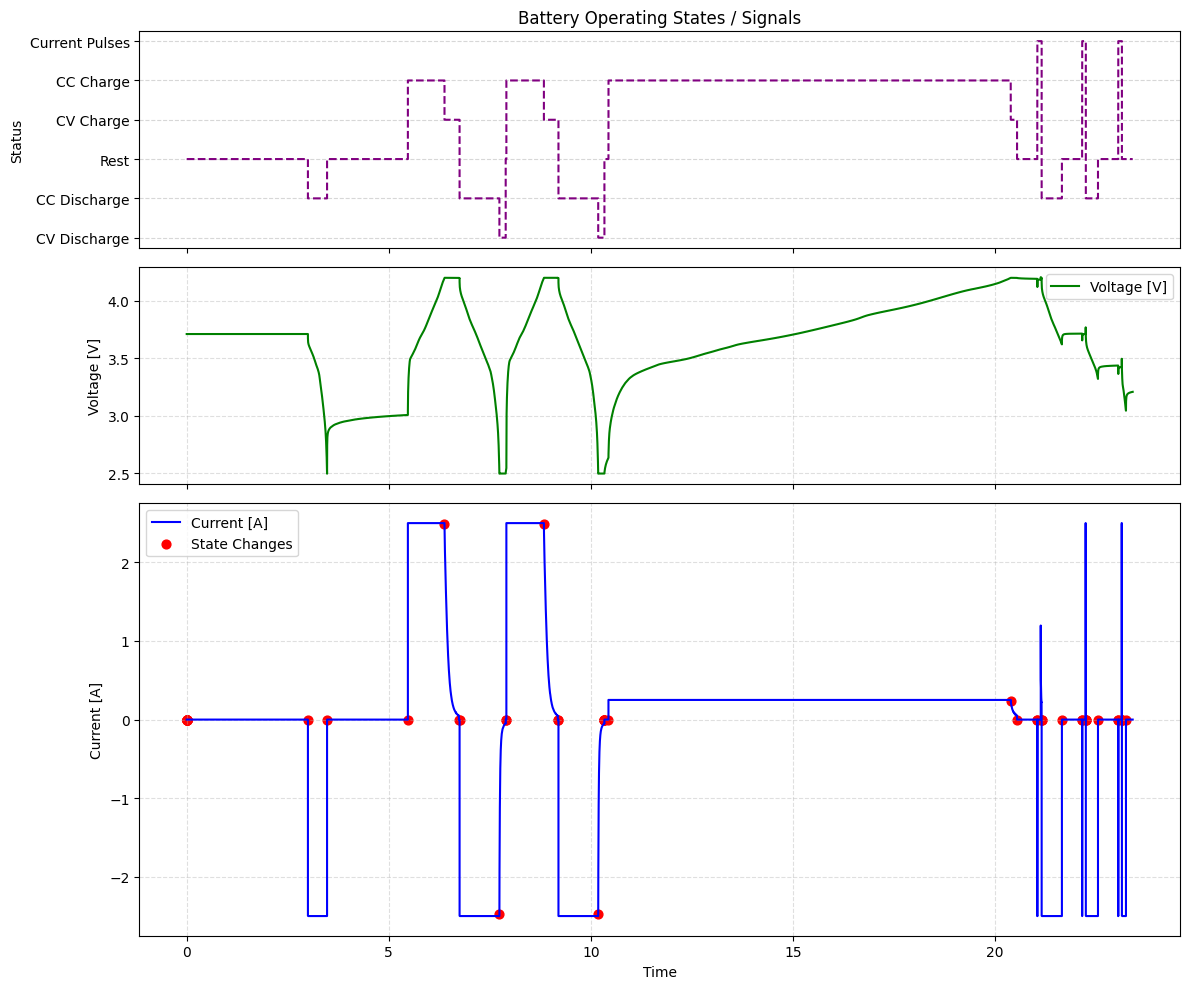

In [ ]:
# All periods graphic
plot_battery_data(df)

/tmp/ipykernel_16583/2889084781.py:50: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["Line"] = pd.to_numeric(data["Line"], errors="coerce").fillna(method="ffill")


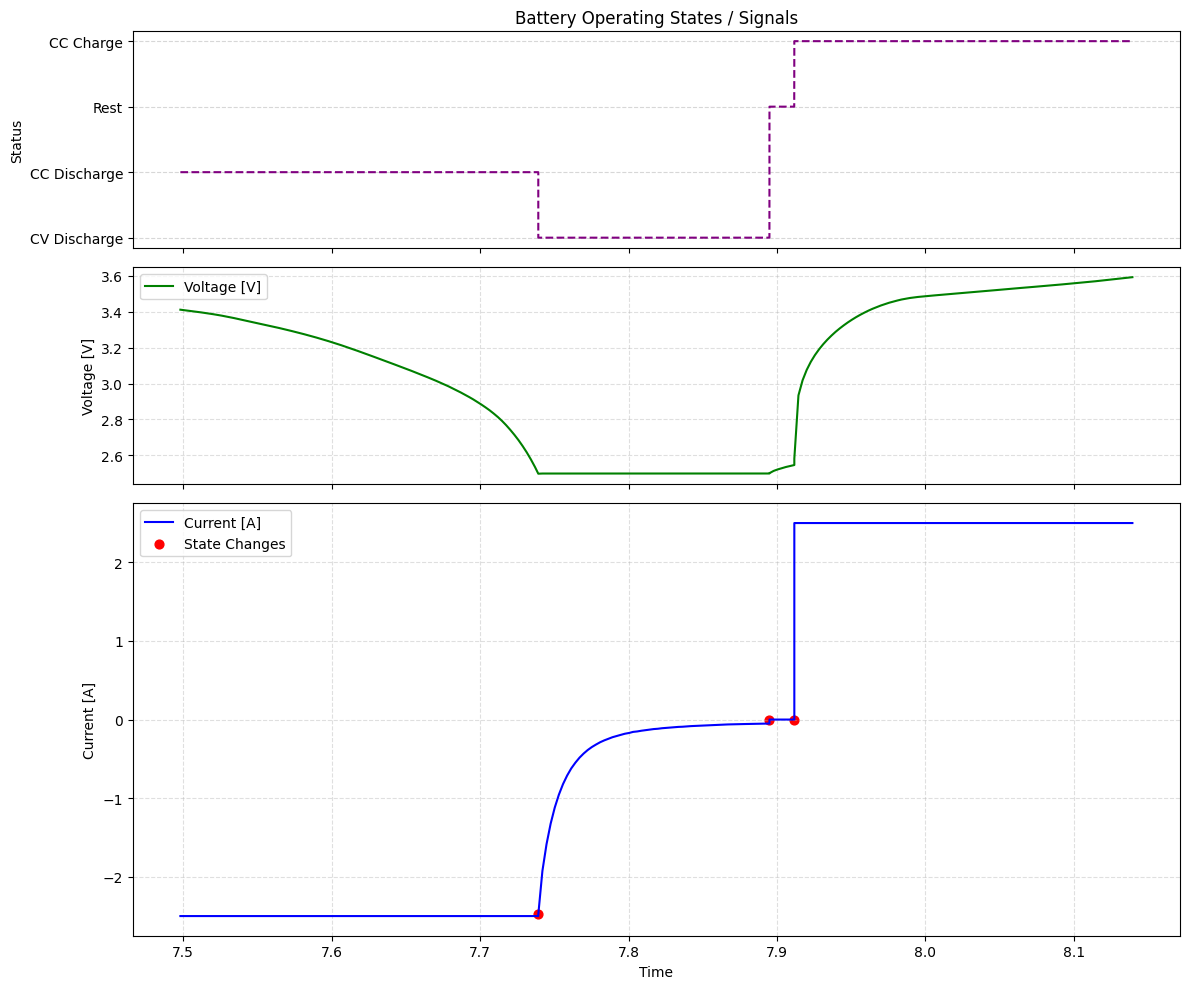

In [ ]:
# Period 6 graphic
plot_battery_data(df, 6, metrics)
